In [143]:
#!pip install pybaseball
from pybaseball import batting_stats
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [144]:
#importing data
#df_bat = batting_stats(2021,2026)

In [145]:
#converting to pickle for easier access
#df_bat.to_pickle("batting_stats_2021_2026.pkl")

In [146]:
#loading pickle
df_bat_load = pd.read_pickle("batting_stats_2021_2026.pkl")

In [147]:
#grouping by id and filtering for all players with at least 1 full season
df_bat_load = df_bat_load.groupby('IDfg', group_keys=False).filter(lambda x: len(x) >= 1)

In [148]:
#creating a next season WAR target variable
def next_season_stats(player):
  player = player.sort_values("Season")
  player['Next_Szn_War'] = player['WAR'].shift(-1)
  return player

df_bat_load = df_bat_load.groupby('IDfg', group_keys=False).apply(next_season_stats)

/tmp/ipython-input-2015820716.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_bat_load = df_bat_load.groupby('IDfg', group_keys=False).apply(next_season_stats)


In [149]:
#grabbing all null columns
null_cols = df_bat_load.isnull().sum()

In [150]:
#filtering out null columns
complete_cols = list(df_bat_load.columns[null_cols == 0])

In [151]:
#merging complete columns and created target variable
df_bat_load = df_bat_load[complete_cols + ['Next_Szn_War']].copy()

In [152]:
#renaming dataframe
batting = df_bat_load

In [153]:
#analyzing columns that are object type
batting.dtypes[batting.dtypes == 'object']

,0
Name,object
Team,object
Dol,object
Age Rng,object


In [154]:
#deleting dol column as it is not needed
del batting['Dol']

In [155]:
#deleting age rng column as it is not needed
del batting['Age Rng']

In [156]:
#creating team code column to quantify the team a player is on
batting['Team_Code'] = batting['Team'].astype('category').cat.codes

In [157]:
#creating a copy of dataframe
batting_copy = batting.copy()

In [158]:
#creating model, time series split, and sequential feature selector
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model = Ridge(alpha = 3)

split = TimeSeriesSplit(n_splits = 3)

feature_selector = SequentialFeatureSelector(model, n_features_to_select=20,
                                     direction = 'forward', cv = split,
                                     n_jobs = 4)

In [159]:
#removing columns that arent going to be used for prediction
removed_cols = ['Next_Szn_War', 'Name', 'Team', 'IDfg', 'Season']
selected_cols = batting.columns[~batting.columns.isin(removed_cols)]

In [160]:
#scaling data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

batting.loc[:, selected_cols] = scaler.fit_transform(batting[selected_cols])

Streaming output truncated to the last 5000 lines.
 0.23529412 0.41176471 0.17647059 0.05882353 0.11764706 0.17647059
 0.11764706 0.05882353 0.17647059 0.11764706 0.17647059 0.17647059
 0.05882353 0.29411765 0.23529412 0.05882353 0.11764706 0.17647059
 0.05882353 0.05882353 0.11764706 0.         0.23529412 0.17647059
 0.11764706 0.05882353 0.05882353 0.05882353 0.17647059 0.17647059
 0.23529412 0.17647059 0.41176471 0.17647059 0.05882353 0.
 0.05882353 0.         0.         0.17647059 0.17647059 0.17647059
 0.11764706 0.11764706 0.         0.         0.11764706 0.11764706
 0.11764706 0.11764706 0.17647059 0.         0.11764706 0.
 0.05882353 0.11764706 0.29411765 0.         0.         0.
 0.17647059 0.17647059 0.17647059 0.         0.05882353 0.11764706
 0.47058824 0.23529412 0.29411765 0.17647059 0.17647059 0.35294118
 0.11764706 0.23529412 0.11764706 0.11764706 0.23529412 0.64705882
 0.17647059 0.23529412 0.23529412 0.47058824 0.11764706 0.05882353
 0.11764706 0.11764706 0.17647059 0

In [161]:
#creating training data and selecting features based on training data
train_rows = batting.dropna(subset=['Next_Szn_War'])

x_train = train_rows[selected_cols]
y_train = train_rows['Next_Szn_War']

feature_selector.fit(x_train, y_train)

SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                          estimator=Ridge(alpha=3), n_features_to_select=20,
                          n_jobs=4)

In [162]:
#getting list of predictors from feature selection
predictors = list(selected_cols[feature_selector.get_support()])

In [163]:
#creating rolling backtest of model, trains on all prior seasons and predicts next season war
#returns actual vs. predicted values for each season.
def backtest(data, model, predictors, start=1, step=1):
  all_predictions = []

  years = sorted(data['Season'].unique())

  for i in range(start, len(years), step):
    current_year = years[i]

    train = data[data['Season'] < current_year].dropna(subset=['Next_Szn_War'])
    test = data[data['Season'] == current_year]

    model.fit(train[predictors], train['Next_Szn_War'])

    predictions = model.predict(test[predictors].fillna(0))
    predictions = pd.Series(predictions, index = test.index)
    combined = pd.concat([test['Next_Szn_War'], predictions], axis = 1)
    combined.columns = ['Actual', 'Predicted']

    all_predictions.append(combined)
  return pd.concat(all_predictions)


In [164]:
#making predictions and dropping na values
predictions = backtest(batting, model, predictors)
predictions = predictions.dropna(subset=['Actual', 'Predicted'])

In [165]:
#finding rmse from mse
from sklearn.metrics import mean_squared_error

print("RMSE: ", (mean_squared_error(predictions['Actual'], predictions['Predicted']))**.5)

RMSE:  1.6023441767615807


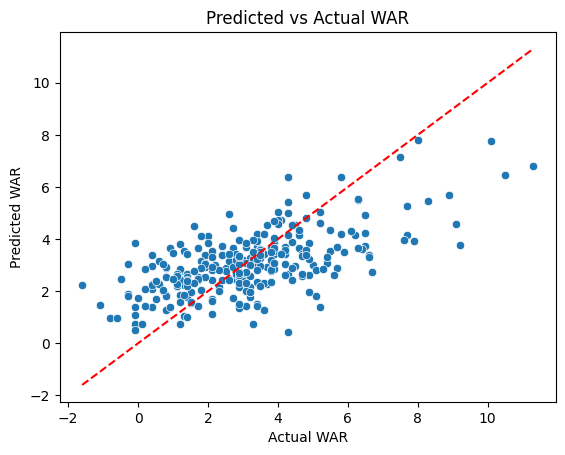

In [166]:
#creating scatterplot of predicted vs actual war
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x='Actual', y='Predicted', data=predictions)
plt.plot([predictions['Actual'].min(), predictions['Actual'].max()],
         [predictions['Actual'].min(), predictions['Actual'].max()],
         color='red', linestyle='--')
plt.xlabel('Actual WAR')
plt.ylabel('Predicted WAR')
plt.title('Predicted vs Actual WAR')
plt.show()

In [167]:
#creating player history function in an attempt to quantify trends in war over time

from math import inf
def player_history(df):
  df = df.sort_values('Season')

  df['Career_Season'] = range(df.shape[0])
  df['War_Correlation'] = list(df[['Career_Season', 'WAR']].expanding().corr().xs('WAR', level=1)['Career_Season'])
  df['War_Correlation'].fillna(1, inplace = True)

  df['War_Difference'] = df['WAR'] / df['WAR'].shift(1)
  df['War_Difference'].fillna(1, inplace = True)

  df['War_Difference'][df['War_Difference'] == np.inf] = 1

  return df

batting = batting.groupby('IDfg', group_keys = False).apply(player_history)

Streaming output truncated to the last 5000 lines.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['War_Correlation'].fillna(1, inplace = True)
/tmp/ipython-input-1164253980.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['War_Difference'].fillna(1, inplace = True)
/tmp/ipython-input-1164253980.py:14: FutureWarning: ChainedAssignmentError: behaviou

In [168]:
#function to returh player's war relative to average war
def group_averages(df):
  return df['WAR'] / df['WAR'].mean()

In [169]:
#calculates each player's war relative to the average war for number season in dataset and assigns it to a new column 'War_Season'
batting['War_Season'] = batting.groupby('Career_Season', group_keys = False).apply(group_averages)

/tmp/ipython-input-608940061.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  batting['War_Season'] = batting.groupby('Career_Season', group_keys = False).apply(group_averages)


In [170]:
#new list of predictors including war trends
new_predictors = predictors + ['Career_Season', 'War_Correlation', 'War_Season', 'War_Difference']

In [171]:
#utilizing backtest function on new predictors to see if they improve rmse
new_predictions = backtest(batting, model, new_predictors)
new_predictions = new_predictions.dropna(subset=['Actual', 'Predicted'])

In [172]:
#did not improve rmse
((mean_squared_error(new_predictions['Actual'], new_predictions['Predicted']))**.5)

1.6303283294613364

In [173]:
#seeing how new predictors influence next season war
pd.Series(model.coef_, index = new_predictors).sort_values()


,0
Age,-1.365020
BABIP,-1.047992
vKC (sc),-0.595408
War_Difference,-0.159600
War_Correlation,-0.150270
Career_Season,0.016753
wSF/C,0.413157
WAR,0.567203
SB,0.583109
RAR,0.616511


In [174]:
#calculating difference in war
diff = predictions['Actual'] - predictions['Predicted']

In [175]:
#merging predictions with batting df to calculate actual vs predicted
merged_predictions = predictions.merge(batting, left_index = True, right_index = True)

In [176]:
#calculating actual vs predicted
merged_predictions['Actual_War_Difference'] = (predictions['Actual'] - predictions['Predicted']).abs()

In [177]:
#renaming columns for clarity
merged_predictions.rename(columns={'Predicted': 'Next_Szn_War_Prediction'}, inplace=True)

In [178]:
#cleaning up predictions for clarity
merged_predictions_cols = merged_predictions[['IDfg', 'Season',  'Name',  'Next_Szn_War_Prediction', 'Next_Szn_War', 'Actual_War_Difference']].sort_values(['Actual_War_Difference'])
merged_predictions
merged_preds_df = pd.DataFrame(merged_predictions_cols.head(10))
merged_preds_df['Next_Szn_War_Prediction'] = merged_preds_df['Next_Szn_War_Prediction'].round(1)
merged_preds_df['Actual_War_Difference'] = merged_preds_df['Actual_War_Difference'].round(1)

In [179]:
#viewing predictions based on the highest projected next season war
merged_predictions_cols.sort_values(['Next_Szn_War_Prediction'], ascending = False)

,IDfg,Season,Name,Next_Szn_War_Prediction,Next_Szn_War,Actual_War_Difference
17,25764,2024,Bobby Witt Jr.,7.803718,8.0,0.196282
0,15640,2024,Aaron Judge,7.772189,10.1,2.327811
5,19755,2024,Shohei Ohtani,7.151793,7.5,0.348207
2,15640,2022,Aaron Judge,6.817941,11.3,4.482059
237,25764,2023,Bobby Witt Jr.,6.469485,10.5,4.030515
...,...,...,...,...,...,...
427,26197,2023,Andrew Vaughn,0.734440,-0.1,0.834440
582,7304,2023,Salvador Perez,0.728416,3.3,2.571584
213,5235,2023,Justin Turner,0.721884,1.2,0.478116
394,9847,2024,Andrew McCutchen,0.522002,-0.1,0.622002


In [180]:
#making predictions for 2026 utilizing original set of predictors

train = batting.dropna(subset=['Next_Szn_War']).copy()
model.fit(train[predictors], train['Next_Szn_War'])

Ridge(alpha=3)

In [181]:
#creating code to take user input to find 2026 predicted war for given player
player_name = input("Enter player name to predict 2026 WAR: ").strip()

player_rows = batting[batting['Name'].str.lower() == player_name.lower()]

future_row = player_rows[player_rows['Season'] == 2025]

if player_rows.empty:
    print(f"No data for {player_name}. Cannot predict 2026 WAR.")
else:
    future_row = player_rows.sort_values('Season', ascending=False).head(1)

    pred = model.predict(future_row[predictors])[0]

    last_season = future_row['Season'].values[0]
    gap = 2026 - last_season - 1

    decay_factor = 0.9 ** gap
    adjusted_pred = pred * decay_factor

    print(f"Predicted WAR for {player_name} in 2026: {adjusted_pred:.1f}")
    if gap >= 1:
       print("Last full season was: ", last_season)
       print("War decayed by: ", (pred - adjusted_pred).round(1))

Enter player name to predict 2026 WAR: Aaron Judge
Predicted WAR for Aaron Judge in 2026: 7.6


In [182]:
#creating dataframe of 2026 predictions
latest_stats = batting.sort_values('Career_Season').groupby('Name').tail(1)

latest_stats['Predicted_WAR'] = model.predict(latest_stats[predictors])

latest_stats['Gap'] = 2026 - latest_stats['Season'] - 1
latest_stats['Decay_Factor'] = 0.9 ** latest_stats['Gap']
latest_stats['Predicted_WAR'] *= latest_stats['Decay_Factor']


predictions_df = latest_stats[['Name', 'Season', 'Predicted_WAR']]
predictions_df['Season'] = 2026
predictions_df['Predicted_WAR'] = predictions_df['Predicted_WAR'].round(1)
predictions_df.sort_values(['Predicted_WAR'], ascending=False).head(10)

/tmp/ipython-input-2510841780.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_df['Season'] = 2026
/tmp/ipython-input-2510841780.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_df['Predicted_WAR'] = predictions_df['Predicted_WAR'].round(1)


,Name,Season,Predicted_WAR
1,Aaron Judge,2026,7.6
29,Cal Raleigh,2026,7.1
119,Bobby Witt Jr.,2026,6.8
34,Juan Soto,2026,6.6
6,Ronald Acuna Jr.,2026,6.5
13,Shohei Ohtani,2026,6.5
62,Corbin Carroll,2026,6.0
121,Jose Ramirez,2026,5.9
66,Geraldo Perdomo,2026,5.7
152,Fernando Tatis Jr.,2026,5.4


In [183]:
#creating dataframe of selected features
features_selected = pd.Series(model.coef_, index = predictors).sort_values()

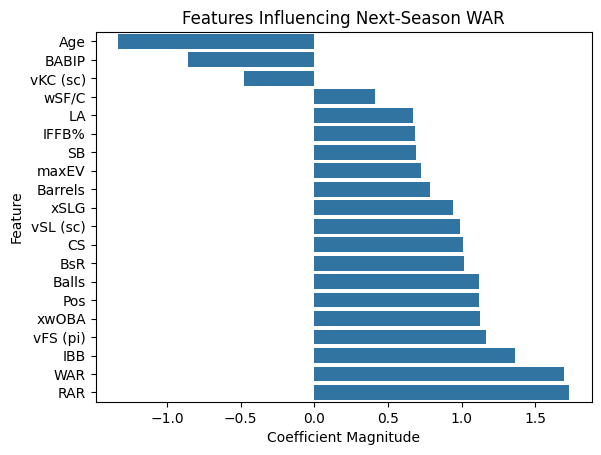

In [184]:
#creating a feature importance horizontal bar chart
sns.barplot(x=features_selected.values, y=features_selected.index)
plt.title('Features Influencing Next-Season WAR')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.show()

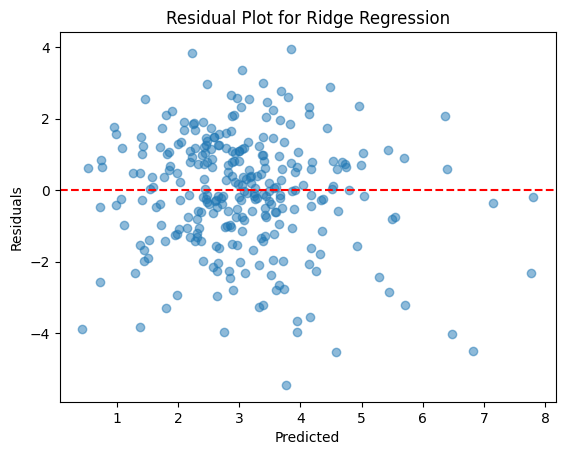

In [185]:
#creating a residual vs predicted plot for further analysis
residuals = merged_predictions_cols['Next_Szn_War_Prediction'] - merged_predictions_cols['Next_Szn_War']
plt.scatter(merged_predictions_cols['Next_Szn_War_Prediction'], residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot for Ridge Regression")
plt.show()